# Anyone AI

# Home Credit Default Risk

Goal: Create a complete pipeline to preprocess the data, train a model and then predict values for the [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.

## Imports and libraries install

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pickle

from time import sleep
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Mounted at /content/drive


## Introduction

Kaggle is a web platform and community for data scientist and machine learning engineers where competetitions and datasets are regularly published.

This particular competition is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay its debt or not. 

The dataset is composed of multiple files with different information about loands taken. In this project we're going to exclusively work with the main files: application_train.csv and application_test.csv.

The competition uses [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

### Getting the data

One row represents one loan in our data sample.
The target variable says wether the loan was repaid (0) or not (1)

2- Load the training and test datasets, we're only going to work withe "application_train.csv" and "application_test.csv" for now

In [ ]:
# In order to work with kaggle API you need to upload "kaggle.json" file, which 
# contains your API Token with the login credentials.

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# Download and unzip only needed files
!kaggle competitions download -c home-credit-default-risk
!unzip home-credit-default-risk.zip -x HomeCredit_columns_description.csv POS_CASH_balance.csv bureau.csv bureau_balance.csv credit_card_balance.csv installments_payments.csv previous_application.csv sample_submission.csv

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes
 99% 682M/688M [00:05<00:00, 145MB/s]
100% 688M/688M [00:05<00:00, 136MB/s]
Archive:  home-credit-default-risk.zip
  inflating: application_test.csv    
  inflating: application_train.csv   


In [ ]:
# Load files
basepath = "/content/"
app_train_df = pd.read_csv(basepath + "application_train.csv")
app_test_df = pd.read_csv(basepath + "application_test.csv")
display(app_train_df.head())
display(app_test_df.head())

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


### Exploratory Data Analysis

**Dataset Basics**

Shape of the training and test datasets.

In [ ]:
print(f"Train dataset: {app_train_df.shape}")
print(f"Test dataset: {app_test_df.shape}")

Train dataset: (307511, 122)
Test dataset: (48744, 121)


List of all columns in the train dataset

In [ ]:
pd.set_option("max_info_columns", 200)

app_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    SK_ID_CURR                    307511 non-null  int64  
 1    TARGET                        307511 non-null  int64  
 2    NAME_CONTRACT_TYPE            307511 non-null  object 
 3    CODE_GENDER                   307511 non-null  object 
 4    FLAG_OWN_CAR                  307511 non-null  object 
 5    FLAG_OWN_REALTY               307511 non-null  object 
 6    CNT_CHILDREN                  307511 non-null  int64  
 7    AMT_INCOME_TOTAL              307511 non-null  float64
 8    AMT_CREDIT                    307511 non-null  float64
 9    AMT_ANNUITY                   307499 non-null  float64
 10   AMT_GOODS_PRICE               307233 non-null  float64
 11   NAME_TYPE_SUITE               306219 non-null  object 
 12   NAME_INCOME_TYPE            

The first 5 records of the training dataset

In [ ]:
pd.set_option('display.max_rows', 200)

app_train_df.head(5).transpose()

,0,1,2,3,4
SK_ID_CURR,100002,100003,100004,100006,100007
TARGET,1,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,M,F,M,F,M
FLAG_OWN_CAR,N,N,Y,N,N
FLAG_OWN_REALTY,Y,N,Y,Y,Y
CNT_CHILDREN,0,0,0,0,0
AMT_INCOME_TOTAL,202500.0,270000.0,67500.0,135000.0,121500.0
AMT_CREDIT,406597.5,1293502.5,135000.0,312682.5,513000.0
AMT_ANNUITY,24700.5,35698.5,6750.0,29686.5,21865.5


Distribution of the target variable values: Total value count and the percentage of each value, plot of this relationship.

Total number of loans: 307511
Number of repaid loans: 282686
Number of not repaid loans: 24825
Percentage of repaid loans: 91.93 %
Percentage of not repaid loans: 8.07 % 




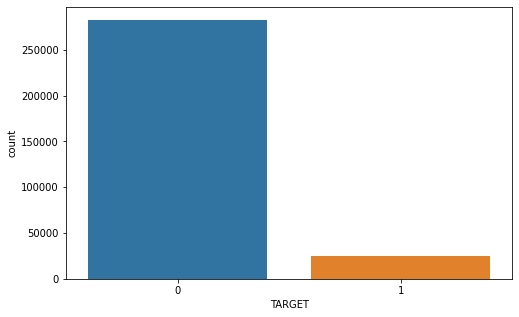

In [ ]:
counts = app_train_df['TARGET'].value_counts()
total = np.sum(counts)
zeros = round((counts[0]/total)*100, 2)
ones = round((counts[1]/total)*100, 2)

print(f"Total number of loans: {total}")
print(f"Number of repaid loans: {counts[0]}")
print(f"Number of not repaid loans: {counts[1]}")

print(f"Percentage of repaid loans: {zeros} %")
print(f"Percentage of not repaid loans: {ones} % \n\n")

sns.countplot(x="TARGET", data=app_train_df)
plt.gcf().set_size_inches(8, 5)
plt.show()

The number of columns of each data type

In [ ]:
app_train_df.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

For categorical variables, number of distinct values in each column (number of labels)

In [ ]:
app_train_df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [ ]:
# Show the distinct categories in each categorical feature

def get_uniques(col):
  if pd.api.types.is_object_dtype(col.dtype):
    print(f"The unique values for {col.name} are:\n")
    print(col.unique())
    print()
    
_ = app_train_df.apply(get_uniques, axis=0)

The unique values for NAME_CONTRACT_TYPE are:

['Cash loans' 'Revolving loans']

The unique values for CODE_GENDER are:

['M' 'F' 'XNA']

The unique values for FLAG_OWN_CAR are:

['N' 'Y']

The unique values for FLAG_OWN_REALTY are:

['Y' 'N']

The unique values for NAME_TYPE_SUITE are:

['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']

The unique values for NAME_INCOME_TYPE are:

['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']

The unique values for NAME_EDUCATION_TYPE are:

['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

The unique values for NAME_FAMILY_STATUS are:

['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']

The unique values for NAME_HOUSING_TYPE are:

['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartm

Analyzing missing data: The percentage of missing data for each column ordered by percentage descending (showing only the 20 columns with higher missing pct)

In [ ]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

col_missing_values = app_train_df.isna().sum().sort_values(ascending=False)
col_missing_values = col_missing_values[col_missing_values != 0]
col_total_values = len(app_train_df)
col_missing_values = col_missing_values.map(lambda col_value: round((col_value/col_total_values) * 100, 2))
col_missing_values.head(20)

COMMONAREA_MEDI             69.87
COMMONAREA_AVG              69.87
COMMONAREA_MODE             69.87
NONLIVINGAPARTMENTS_MODE    69.43
NONLIVINGAPARTMENTS_AVG     69.43
NONLIVINGAPARTMENTS_MEDI    69.43
FONDKAPREMONT_MODE          68.39
LIVINGAPARTMENTS_MODE       68.35
LIVINGAPARTMENTS_AVG        68.35
LIVINGAPARTMENTS_MEDI       68.35
FLOORSMIN_AVG               67.85
FLOORSMIN_MODE              67.85
FLOORSMIN_MEDI              67.85
YEARS_BUILD_MEDI            66.50
YEARS_BUILD_MODE            66.50
YEARS_BUILD_AVG             66.50
OWN_CAR_AGE                 65.99
LANDAREA_MEDI               59.38
LANDAREA_MODE               59.38
LANDAREA_AVG                59.38
dtype: float64

**Analyzing distribution of variables**

The distribution of credit amounts

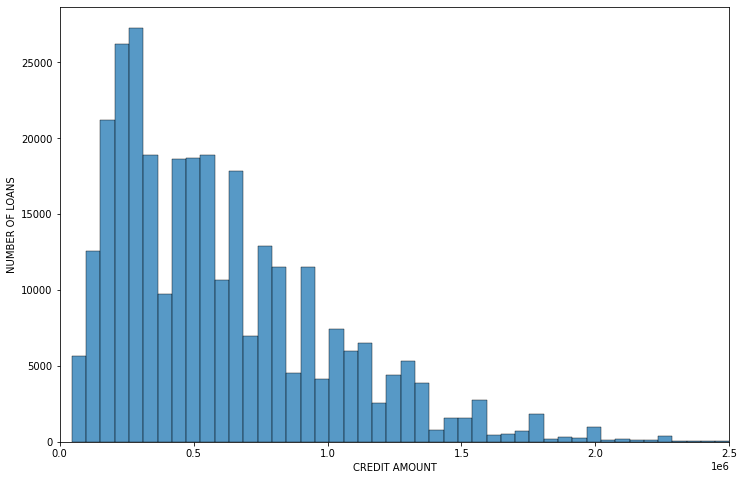

In [ ]:
plot = sns.histplot(x='AMT_CREDIT', data=app_train_df, bins=75)
plot.set_xlim(0, 2500000)
plot.set_xlabel('CREDIT AMOUNT')
plot.set_ylabel('NUMBER OF LOANS')
plt.gcf().set_size_inches(12, 8)
plt.show()

Plot of the education level of the credit applicants, showing the percentages of each category. Also the total counts for each category.

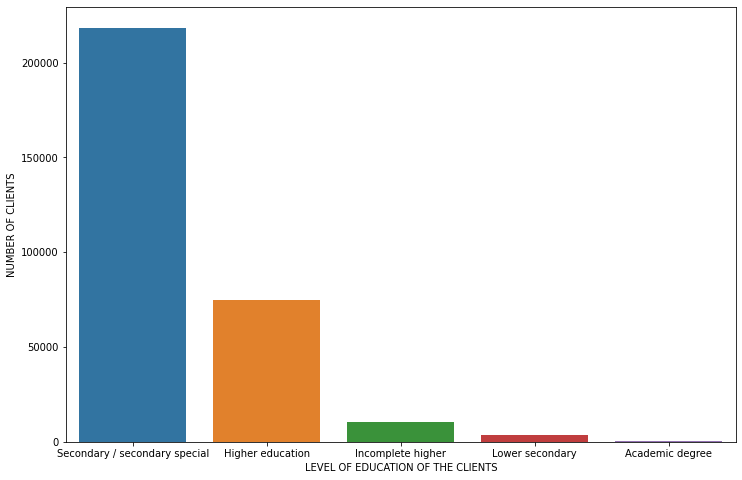


Percentages of education level



Secondary / secondary special    71.02
Higher education                 24.34
Incomplete higher                 3.34
Lower secondary                   1.24
Academic degree                   0.05
Name: NAME_EDUCATION_TYPE, dtype: float64


Total counts of education level



Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

In [ ]:
plot = sns.countplot(x='NAME_EDUCATION_TYPE', data=app_train_df)
plot.set_xlabel('LEVEL OF EDUCATION OF THE CLIENTS')
plot.set_ylabel('NUMBER OF CLIENTS')
plt.gcf().set_size_inches(12, 8)
plt.show()

print()
print('Percentages of education level')
print()
display(app_train_df['NAME_EDUCATION_TYPE'].value_counts(normalize=True).map(lambda x: round(x*100, 2)))
print()
print('Total counts of education level')
print()
display(app_train_df['NAME_EDUCATION_TYPE'].value_counts())

Plot of the distribution of ocupation of the loan applicants

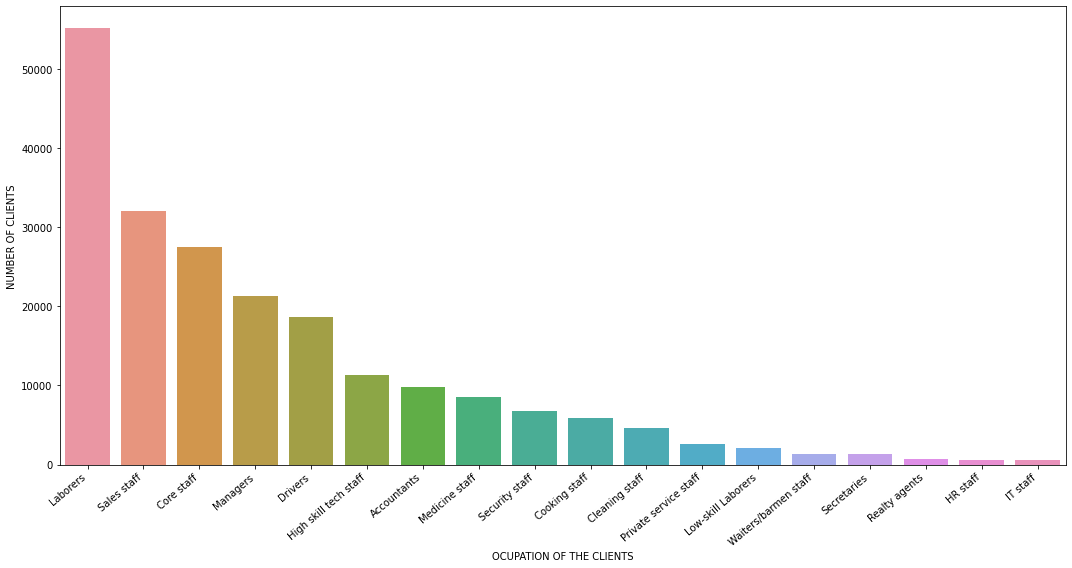

In [ ]:
plot = sns.countplot(x='OCCUPATION_TYPE', data=app_train_df, order=app_train_df['OCCUPATION_TYPE'].value_counts().index)
plot.set_xticklabels(plot.get_xticklabels(), rotation=40, ha="right")
plot.set_xlabel('OCUPATION OF THE CLIENTS')
plot.set_ylabel('NUMBER OF CLIENTS')
plt.gcf().set_size_inches(15, 8)
plt.tight_layout()
plt.show()

Plot of the family status of the applicants

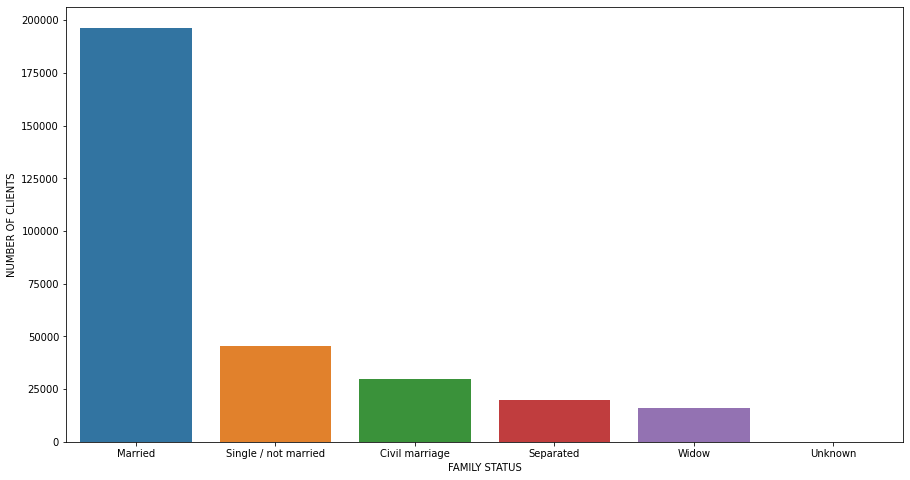

In [ ]:
plot = sns.countplot(x='NAME_FAMILY_STATUS', data=app_train_df, order=app_train_df['NAME_FAMILY_STATUS'].value_counts().index)
plot.set_xlabel('FAMILY STATUS')
plot.set_ylabel('NUMBER OF CLIENTS')
plt.gcf().set_size_inches(15, 8)
plt.show()

Plot of the income type of applicants grouped by the target variable

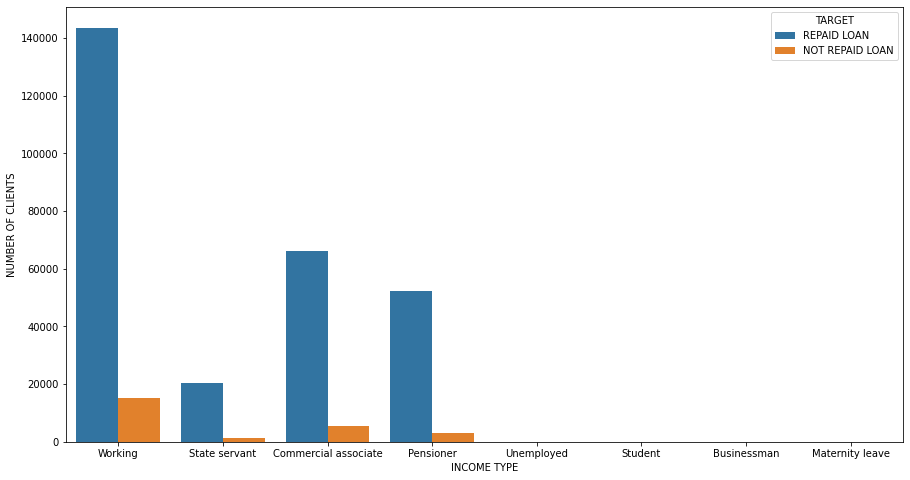

In [ ]:
plot = sns.countplot(x='NAME_INCOME_TYPE', hue='TARGET', data=app_train_df)
plot.set_xlabel('INCOME TYPE')
plot.set_ylabel('NUMBER OF CLIENTS')
plt.legend(title='TARGET', loc='upper right', labels=['REPAID LOAN', 'NOT REPAID LOAN'])
plt.gcf().set_size_inches(15, 8)
plt.show()

## Preprocessing

Coding a function to make all the data pre processing for the dataset. The function takes the train and test dataframes, processes all features, and returns the transformed data as numpy arrays ready to be used for training.

The function perform these activities:

- Correct outliers/anomalous values in numerical columns
- Impute values for all columns with missing data (using median as imputing value)
- Encode categorical features:
    - If feature has 2 categories encode using binary encoding
    - More than 2 categories, use one hot encoding 
- Feature scaling

### Taking a look at DAYS_EMPLOYED column

In [ ]:
# Dividing by -365 to see positive years

(app_train_df['DAYS_EMPLOYED'] / -365).describe()

count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: DAYS_EMPLOYED, dtype: float64

In [ ]:
app_train_df['DAYS_EMPLOYED'].sort_values().tail(10)

72079     365243
141250    365243
141251    365243
268780    365243
72066     365243
268782    365243
72057     365243
72056     365243
268773    365243
253780    365243
Name: DAYS_EMPLOYED, dtype: int64

In [ ]:
app_train_df['DAYS_EMPLOYED'].value_counts()

 365243    55374
-200         156
-224         152
-230         151
-199         151
           ...  
-13961         1
-11827         1
-10176         1
-9459          1
-8694          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

In [ ]:
len(app_train_df[app_train_df['DAYS_EMPLOYED'] == 365243])

55374

`There is an anomalous value in the 'DAYS_EMPLOYED' feature equals to "365243", and it repeats 55374 times. Searching in kaggle it is found this: "Value 365243 denotes infinity in DAYS variables in the datasets, therefore you can consider them NA values. Also XNA/XAP denote NA values." Given that answer, I'll check the other DAYS columns for any anomalies.`

In [ ]:
for col in app_train_df.columns.values:
  if 'DAYS' in col:
    anom_count = len(app_train_df[app_train_df[col] == 365243])
    print(f"{col} has {anom_count} anomalies values")

DAYS_BIRTH has 0 anomalies values
DAYS_EMPLOYED has 55374 anomalies values
DAYS_REGISTRATION has 0 anomalies values
DAYS_ID_PUBLISH has 0 anomalies values
DAYS_LAST_PHONE_CHANGE has 0 anomalies values


`Only DAYS_EMPLOYED has anomalies of that kind`

### Preprocessing class

In [ ]:
class DataPreprocessor:
  """Modularized Dataset Preprocessing."""

  def __init__(self, train, test):
    assert type(train) == pd.DataFrame, 'train must be a DataFrame'
    assert type(test) == pd.DataFrame, 'test must be a DataFrame'

    self.train = train.copy()
    self.train_labels = train['TARGET'].copy()
    self.test = test.copy()
    self.columns = None # Name of the features after encoding

  def preprocess(self, dump=False, dump_path=None, return_colnames=True):
    """Preprocessing pipeline. Return the following arrays: train (without labels),
    train_labels and test. Also you can choose if dump or not the datasets in pickle
    format for future use.
    """

    self.feature_encoding()
    self.datasets_align()
    self.anomalies_proc()

    self.columns = list(self.train.columns.values) if return_colnames else None

    self.feature_scaling_imputing()

    print('train shape: ', self.train.shape)
    print('train_labels shape: ', self.train_labels.shape)
    print('test shape: ', self.test.shape)

    if(dump):
      assert type(dump_path) == str, 'dump_path must be a str'

      with open(dump_path + 'train.pkl', 'wb') as outp:
        pickle.dump(self.train, outp, pickle.HIGHEST_PROTOCOL)
        print(f'train dumped to {dump_path}train.pkl')

      with open(dump_path + 'train_labels.pkl', 'wb') as outp:
        pickle.dump(self.train_labels, outp, pickle.HIGHEST_PROTOCOL)
        print(f'train_labels dumped to {dump_path}train_labels.pkl') 
      
      with open(dump_path + 'test.pkl', 'wb') as outp:
        pickle.dump(self.test, outp, pickle.HIGHEST_PROTOCOL)
        print(f'test dumped to {dump_path}test.pkl')
      
    return_val_wcol = (self.train, self.train_labels, self.test, self.columns)
    return_val = (self.train, self.train_labels, self.test)

    return return_val_wcol if return_colnames else return_val

  def feature_encoding(self):
    """Encode binary categorical features using sklearn LabelEncoder(), and categorical
    features using pandas get_dummies().
    """
    
    # Binary encoding col by col

    label_enc = LabelEncoder()
    bincat_feat = 0

    for col in self.train: 
      cond1 = self.train[col].dtype == 'object' # Is categorical?
      cond2 = self.train[col].nunique() <= 2 # Is binary?

      if cond1 and cond2:
        label_enc.fit(self.train[col])
        self.train[col] = label_enc.transform(self.train[col])
        self.test[col] = label_enc.transform(self.test[col])
        bincat_feat += 1

    print(f"{bincat_feat} columns were binary encoded")

    # One-hot encoding

    cat_feat = len(self.train.select_dtypes(exclude='number').columns.tolist())

    self.train = pd.get_dummies(self.train)
    self.test = pd.get_dummies(self.test)

    print(f"{cat_feat} columns were one-hot encoded")

  def datasets_align(self):
    """Align the datasets to match the features after encoding."""

    self.train, self.test = self.train.align(self.test, join = 'inner', axis = 1)
    print('Train and test features were aligned')

  def anomalies_proc(self):
    """Replace anomalies in DAYS_EMPLOYED with NaN and create a column indicating 
    if that replacing took place to avoid loosing potential information.
    """

    self.train['DAYS_EMPLOYED_ANOM'] = self.train["DAYS_EMPLOYED"] == 365243
    self.train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    print('Infinite values in DAYS_EMPLOYED from train were replaced by NaN')

    self.test['DAYS_EMPLOYED_ANOM'] = self.test["DAYS_EMPLOYED"] == 365243
    self.test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)
    print('Infinite values in DAYS_EMPLOYED from test were replaced by NaN')

  def feature_scaling_imputing(self):
    """Scale numerical features with StandarScaler() and impute
    missing values with a median strategy.
    """

    imputer = SimpleImputer(strategy = 'median')
    scaler = StandardScaler()

    self.train = imputer.fit_transform(self.train)
    self.test = imputer.transform(self.test)
    print('train and test datasets were imputed with median')

    self.train = scaler.fit_transform(self.train)
    self.test = scaler.transform(self.test)
    print('train and test datasets were standard scaled')

  def remove_id(self):
    """Remove ID feature."""

    self.train = self.train.drop(columns = ['SK_ID_CURR'])
    self.test = self.test.drop(columns = ['SK_ID_CURR'])
    print('train and test datasets have ID feature removed')

In [ ]:
preprocessor = DataPreprocessor(app_train_df, app_test_df)

train, train_labels, test, columns = preprocessor.preprocess(dump=True, dump_path='/content/drive/MyDrive/ANYONE_AI/Sprint3/')

4 columns were binary encoded
12 columns were one-hot encoded
Train and test features were aligned
Infinite values in DAYS_EMPLOYED from train were replaced by NaN
Infinite values in DAYS_EMPLOYED from test were replaced by NaN
train and test datasets were imputed with median
train and test datasets were standard scaled
train shape:  (307511, 239)
train_labels shape:  (307511,)
test shape:  (48744, 239)
train dumped to /content/drive/MyDrive/ANYONE_AI/Sprint3/train.pkl
train_labels dumped to /content/drive/MyDrive/ANYONE_AI/Sprint3/train_labels.pkl
test dumped to /content/drive/MyDrive/ANYONE_AI/Sprint3/test.pkl


## Training Models

Start training simple model as baseline and progressively move to more complex models and pipelines.

### Baseline: LogisticRegression

Starting with LogisticRegression from sklearn and training a model using the preprocesed train data from the previous section, and just default parameters.

In [ ]:
%%time

baseline_model = LogisticRegression(random_state=21, C=0.0001, n_jobs=-1, verbose=3)
baseline_model.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 1.35 s, sys: 2.3 s, total: 3.65 s
Wall time: 1min 8s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.1min finished


Using the trained model to predict probabilites for the test data, and then saving the results to a csv in the format expected in the competition: a SK_ID_CURR column and a TARGET column with probabilities.

In [ ]:
baseline_pred = baseline_model.predict_proba(test)[:, 1]

# Submission dataframe
submit = app_test_df[['SK_ID_CURR']].copy()
submit['TARGET'] = baseline_pred

submit.to_csv('submission.csv', index=False)

Submitting results to kaggle. Reporting here the result in the private score.

In [ ]:
!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Baseline Model preprocessed without ID col"

100% 1.26M/1.26M [00:02<00:00, 464kB/s] 
Successfully submitted to Home Credit Default Risk

In [ ]:
# Show last submission 

!kaggle competitions submissions -c home-credit-default-risk --csv > submissions.csv
pd.read_csv('./submissions.csv').head(1)

,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2022-05-20 14:56:28,Baseline Model preprocessed without ID col,complete,0.73296,0.7299


`For some reason, this baseline model gives us an unexpectedly high score. The rest of the models will have a hard time trying to overcome it.` 😆

### Training a Random Forest Classifier 

Using more complex models: ensambles, particularly, the Random Forest Classifier from Scikit Learn. 

Training a RandomForestClassifier, printing the time taken by the fit function. Just using default hyperparameters, except for n_jobs, which should be set to "-1" to allow the library to use all CPU cores to speed up training time.

In [ ]:
%%time

random_forest = RandomForestClassifier(random_state=21, verbose=3, n_jobs=-1)
random_forest.fit(train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100building tree 4 of 100

building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   55.1s


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.2min finished


2- Use the classifier to predict probabilities on the test set, and save the results to a csv file.

In [ ]:
# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

# Submission dataframe
submit = app_test_df[['SK_ID_CURR']].copy()
submit['TARGET'] = predictions

submit.to_csv('submission.csv', index=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.2s finished


3- Load the predictions to the competition. Report the private score here.

In [ ]:
# Submit to kaggle, wait for evaluation and get the results

!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "RandomForest Model without ID col"
sleep(10)
!kaggle competitions submissions -c home-credit-default-risk --csv > submissions.csv
pd.read_csv('./submissions.csv').head(1)

100% 567k/567k [00:04<00:00, 127kB/s]
Successfully submitted to Home Credit Default Risk

,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2022-05-20 15:10:25,RandomForest Model without ID col,complete,0.69628,0.69393


#### Feature importances

In [ ]:
# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': columns, 'importance': feature_importance_values})
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
32,EXT_SOURCE_2,0.049562
33,EXT_SOURCE_3,0.045872
10,DAYS_BIRTH,0.032435
13,DAYS_ID_PUBLISH,0.031921
12,DAYS_REGISTRATION,0.031412
0,SK_ID_CURR,0.030314
11,DAYS_EMPLOYED,0.029847
7,AMT_ANNUITY,0.029061
82,DAYS_LAST_PHONE_CHANGE,0.028375
6,AMT_CREDIT,0.027238


### Randomized Search with Cross Validation

Using RandomizedSearchCV to find the best combination of hyperparameters for a RandomForestClassifier. The validation metric used to evaluate the models is "roc_auc".

In [ ]:
hyperparameter_grid = {
 'max_depth': [10, 50, 100],
 'max_features': ['sqrt'],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200]
}


forest_cv = RandomizedSearchCV(RandomForestClassifier(), hyperparameter_grid, random_state=21,
                              scoring='roc_auc', n_jobs=-1, cv=8, n_iter=5, verbose=3)
forest_cv.fit(train, train_labels)

In [ ]:
# To load dumped forest_cv object from previous session

with open('/content/drive/MyDrive/ANYONE_AI/Sprint3/forest_cv1.pkl', 'rb') as inp:
    forest_cv = pickle.load(inp)

In [ ]:
# Show results ordered by score

pd.DataFrame(forest_cv.cv_results_).sort_values(by='rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
3,258.978911,6.615691,2.215944,0.039949,200,10,sqrt,10,"{'n_estimators': 200, 'min_samples_split': 10,...",0.730959,0.733325,0.736622,0.731986,0.726195,0.732949,0.736757,0.731245,0.732505,0.003162,1
4,481.714358,13.336584,4.645800,0.549784,200,10,sqrt,50,"{'n_estimators': 200, 'min_samples_split': 10,...",0.727415,0.724897,0.724016,0.722865,0.715053,0.722564,0.723440,0.726927,0.723397,0.003568,2
2,516.332932,21.499124,5.468308,0.159214,200,2,sqrt,50,"{'n_estimators': 200, 'min_samples_split': 2, ...",0.723866,0.722706,0.720366,0.717246,0.714348,0.721129,0.721848,0.721722,0.720404,0.002922,3
0,228.248965,4.819505,2.337881,0.196835,100,10,sqrt,50,"{'n_estimators': 100, 'min_samples_split': 10,...",0.718764,0.720277,0.718315,0.716404,0.708473,0.718357,0.717210,0.720647,0.717306,0.003590,4
1,308.362928,47.253610,2.800988,0.107180,100,2,sqrt,50,"{'n_estimators': 100, 'min_samples_split': 2, ...",0.713426,0.714215,0.711473,0.705908,0.705277,0.711740,0.715160,0.714352,0.711444,0.003582,5


Using the classifier to predict probabilities on the test set, and saving the results to a csv file.

In [ ]:
best_randforest = forest_cv.best_estimator_

# Make predictions on the test data
predictions = best_randforest.predict_proba(test)[:, 1]

# Submission dataframe
submit = app_test_df[['SK_ID_CURR']].copy()
submit['TARGET'] = predictions

submit.to_csv('submission.csv', index=False) 

Loading the predictions to the competition. Reporting the private score here.

In [ ]:
# Upload to kaggle and show the score

!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Best RandomForest Model"
sleep(10)
!kaggle competitions submissions -c home-credit-default-risk --csv > submissions.csv
pd.read_csv('./submissions.csv').head(1)

100% 1.25M/1.25M [00:03<00:00, 421kB/s]
Successfully submitted to Home Credit Default Risk

,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2022-05-20 18:03:38,Best RandomForest Model,complete,0.72017,0.72029


Train the model for longer iterations, and using more estimator sizes.

`Here I show the four best results from a night of training in my local environment. I'm showing them in this format (and not in a nicer DataFrame format) because I had to interrupt the kernel after 10 hours of training, and couldn't save the RandomSearchCV object. All that remains was the log in the terminal.`


```
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=200;, score=0.742 total time=31.2min
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=200;, score=0.743 total time=30.4min
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=200;, score=0.736 total time=31.0min
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=200;, score=0.741 total time=30.2min
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=20, min_samples_split=20, n_estimators=200;, score=0.745 total time=31.3min
```

```
[CV 1/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.741 total time=28.7min\
[CV 2/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.744 total time=30.4min\
[CV 3/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.738 total time=29.8min\
[CV 4/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.742 total time=29.7min\
[CV 5/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=35, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.745 total time=30.8min
```

```
[CV 1/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=200;, score=0.741 total time= 9.6min\
[CV 2/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=200;, score=0.742 total time= 9.6min\
[CV 3/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=200;, score=0.735 total time= 9.5min\
[CV 4/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=200;, score=0.739 total time= 9.6min\
[CV 5/5] END class_weight=balanced_subsample, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=20, n_estimators=200;, score=0.743 total time= 9.6min
```

```
[CV 1/5] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.740 total time=14.8min\
[CV 2/5] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.742 total time=15.0min\
[CV 3/5] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.735 total time=15.1min\
[CV 4/5] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.740 total time=22.9min\
[CV 5/5] END class_weight=balanced, criterion=entropy, max_depth=20, max_features=sqrt, min_samples_leaf=50, min_samples_split=50, n_estimators=250;, score=0.744 total time=22.9min
```



#### Feature importances

In [ ]:
# Extract feature importances
feature_importance_values = best_randforest.feature_importances_
feature_importances = pd.DataFrame({'feature': columns, 'importance': feature_importance_values})
feature_importances.sort_values(by='importance', ascending=False).head(10)

,feature,importance
33,EXT_SOURCE_3,0.159801
32,EXT_SOURCE_2,0.156704
31,EXT_SOURCE_1,0.055538
11,DAYS_EMPLOYED,0.045787
10,DAYS_BIRTH,0.034795
82,DAYS_LAST_PHONE_CHANGE,0.023212
8,AMT_GOODS_PRICE,0.021207
13,DAYS_ID_PUBLISH,0.017553
126,NAME_EDUCATION_TYPE_Higher education,0.016835
6,AMT_CREDIT,0.016753


### Optional: Training a LightGBM model 

Gradient Boosting Machine is one of the most used machine learning algorithms for tabular data. Lots of competitions have been won using models from libraries like XGBoost or LightGBM. Using [LightGBM](https://lightgbm.readthedocs.io/en/latest/) to train a new model an see how it performs compared to the other classifiers you trained. 

In [ ]:
%%time

hyperparameter = {
    'num_leaves': [15, 30, 60],
    'max_depth': [5, 10, 15],
    'min_child_samples': [25, 50, 75],
    'n_estimators': [100, 150],
    'class_weight': ['balanced'],
    'objective': ['binary'],
    'learning_rate': [0.05, 0.1]
}

lgb_cv = RandomizedSearchCV(lgb.LGBMClassifier(), hyperparameter, random_state=21,
                         scoring='roc_auc', cv=5, n_iter=10, verbose=3)

lgb_cv.fit(train, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced, score=0.755, total=   6.8s
[CV] objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s remaining:    0.0s


[CV]  objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced, score=0.754, total=   5.6s
[CV] objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.4s remaining:    0.0s


[CV]  objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced, score=0.748, total=   6.2s
[CV] objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced 
[CV]  objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced, score=0.756, total=   6.9s
[CV] objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced 
[CV]  objective=binary, num_leaves=30, n_estimators=100, min_child_samples=75, max_depth=10, learning_rate=0.05, class_weight=balanced, score=0.746, total=   6.2s
[CV] objective=binary, num_leaves=60, n_estimators=150, min_child_samples=75, max_depth=15, learning_rate=0.1, class_weight=balanced 
[CV]  objective=binary, num_leaves=60, n_estimators=150, min_child_samples=75, max_depth=15, learning_rate=

[CV]  objective=binary, num_leaves=30, n_estimators=150, min_child_samples=75, max_depth=10, learning_rate=0.1, class_weight=balanced, score=0.758, total=   6.0s
[CV] objective=binary, num_leaves=30, n_estimators=150, min_child_samples=75, max_depth=10, learning_rate=0.1, class_weight=balanced 
[CV]  objective=binary, num_leaves=30, n_estimators=150, min_child_samples=75, max_depth=10, learning_rate=0.1, class_weight=balanced, score=0.757, total=   5.9s
[CV] objective=binary, num_leaves=30, n_estimators=150, min_child_samples=75, max_depth=10, learning_rate=0.1, class_weight=balanced 
[CV]  objective=binary, num_leaves=30, n_estimators=150, min_child_samples=75, max_depth=10, learning_rate=0.1, class_weight=balanced, score=0.748, total=   6.0s
[CV] objective=binary, num_leaves=30, n_estimators=150, min_child_samples=75, max_depth=10, learning_rate=0.1, class_weight=balanced 
[CV]  objective=binary, num_leaves=30, n_estimators=150, min_child_samples=75, max_depth=10, learning_rate=0.1, 

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  5.4min finished


CPU times: user 35min, sys: 9.07 s, total: 35min 10s
Wall time: 5min 29s


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, sile...
                                            subsample_freq=0),
                   iid='deprecated', n_iter=10, n_jobs=None,
 

In [ ]:
# RandomSearch results
pd.DataFrame(lgb_cv.cv_results_).sort_values(by='rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_num_leaves,param_n_estimators,param_min_child_samples,param_max_depth,param_learning_rate,param_class_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,6.137573,0.367238,0.162087,0.012590,binary,30,150,75,10,0.1,balanced,"{'objective': 'binary', 'num_leaves': 30, 'n_e...",0.758098,0.757437,0.747525,0.756943,0.753981,0.754797,0.003899,1
5,7.340633,0.496949,0.167453,0.014045,binary,30,150,75,15,0.05,balanced,"{'objective': 'binary', 'num_leaves': 30, 'n_e...",0.757895,0.757395,0.750244,0.758496,0.749790,0.754764,0.003894,2
3,5.478251,0.270153,0.112988,0.005098,binary,30,100,25,15,0.1,balanced,"{'objective': 'binary', 'num_leaves': 30, 'n_e...",0.757984,0.756802,0.747597,0.758438,0.751562,0.754477,0.004224,3
2,7.000262,0.363432,0.165471,0.010702,binary,30,150,50,15,0.05,balanced,"{'objective': 'binary', 'num_leaves': 30, 'n_e...",0.757986,0.757532,0.750663,0.758811,0.747033,0.754405,0.004698,4
4,8.230528,0.699356,0.203140,0.020071,binary,60,150,25,10,0.05,balanced,"{'objective': 'binary', 'num_leaves': 60, 'n_e...",0.757377,0.757670,0.751383,0.759058,0.746151,0.754328,0.004866,5
7,4.667091,0.158690,0.106571,0.007372,binary,15,100,50,15,0.1,balanced,"{'objective': 'binary', 'num_leaves': 15, 'n_e...",0.757750,0.756509,0.749251,0.757226,0.744841,0.753115,0.005163,6
0,6.214484,0.468343,0.114020,0.007830,binary,30,100,75,10,0.05,balanced,"{'objective': 'binary', 'num_leaves': 30, 'n_e...",0.755195,0.754288,0.748254,0.756302,0.746364,0.752080,0.003993,7
9,6.133135,0.628132,0.119525,0.018066,binary,30,100,25,15,0.05,balanced,"{'objective': 'binary', 'num_leaves': 30, 'n_e...",0.754976,0.754937,0.748202,0.756162,0.744565,0.751769,0.004566,8
1,7.043274,0.437330,0.183819,0.014879,binary,60,150,75,15,0.1,balanced,"{'objective': 'binary', 'num_leaves': 60, 'n_e...",0.754710,0.756359,0.745379,0.756036,0.743607,0.751218,0.005547,9
8,4.981766,0.214547,0.109072,0.004810,binary,15,100,50,15,0.05,balanced,"{'objective': 'binary', 'num_leaves': 15, 'n_e...",0.752196,0.752576,0.745680,0.753145,0.746287,0.749977,0.003280,10


In [ ]:
# Make predictions on the test data
best_lgb = lgb_cv.best_estimator_
predictions = best_lgb.predict_proba(test)[:, 1]

# Submission dataframe
submit = app_test_df[['SK_ID_CURR']].copy()
submit['TARGET'] = predictions

submit.to_csv('submission.csv', index=False)

In [ ]:
# Upload to kaggle and show the score

!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Best LightGBM Model"
sleep(10)
!kaggle competitions submissions -c home-credit-default-risk --csv > submissions.csv
pd.read_csv('./submissions.csv').head(1)

100%|██████████████████████████████████████| 1.22M/1.22M [00:14<00:00, 86.2kB/s]
Successfully submitted to Home Credit Default Risk

,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2022-05-20 17:39:57,Best LightGBM Model,complete,0.7464,0.74245


### Using Scikit Learn Pipelines 

Using a [Sklearn Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to process the data.

In [ ]:
train_pipe_df = app_train_df.drop(columns=['TARGET']).copy()
test_pipe_df = app_test_df.copy()

# Get categorical, binary categorical and numerical features

numerical_features = train_pipe_df.select_dtypes(include='number').columns.tolist() 
cat_features = train_pipe_df.select_dtypes(exclude='number').columns.tolist() 
bin_cat_features = [] 

for col in cat_features:
  if app_train_df[col].nunique() <= 2: # Is binary?
    bin_cat_features.append(col)

cat_features = list(set(cat_features) - set(bin_cat_features))

# Pipelines for each feature type

numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('encode', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

bin_cat_pipeline = Pipeline(steps=[
    ('encode', OrdinalEncoder()) 
])

# Column transformer for all the pipelines

full_processor = ColumnTransformer(transformers=[
    ('number', numeric_pipeline, numerical_features),
    ('cat', cat_pipeline, cat_features),
    ('bin_cat', bin_cat_pipeline, bin_cat_features)], 
    verbose=True, verbose_feature_names_out=True)

In [ ]:
# Fit full_processor and transform both datasets

full_processor.fit(train_pipe_df)
proc_train_pipe_df = full_processor.transform(train_pipe_df)
proc_test_pipe_df = full_processor.transform(test_pipe_df)

[ColumnTransformer] ........ (1 of 3) Processing number, total=   7.6s
[ColumnTransformer] ........... (2 of 3) Processing cat, total=   1.3s
[ColumnTransformer] ....... (3 of 3) Processing bin_cat, total=   0.6s


In [ ]:
print(proc_train_pipe_df.shape)
print(proc_test_pipe_df.shape)

(307511, 246)
(48744, 246)


## GPU Training

Using [Rapids Framework](https://rapids.ai/).  Rapids has libraries that emulates the interface of pandas, scikit-learn, and other well known frameworks, but they work on the GPU. Here I use cuML, which is like scikit-learn. There is a way to use the framework on colab, but it depends on the type of GPU that google allocates in the current colab session (must be Tesla T4, P4, or P100). Google doesn't usually give you one of those GPUs, so I decided to use the framework locally in my PC with an Nvidia 1050Ti. Anyway, I left the neccesary code to use Rapids here. The decrease in processing time is very high.

#### Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

Check the output of `!nvidia-smi` to make sure you've been allocated a Tesla T4, P4, or P100.

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#### Install Rapids framework on Colab

Set up script installs
1. Updates gcc in Colab
1. Installs Conda
1. Install RAPIDS' current stable version of its libraries, as well as some external libraries including:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuSignal
  1. BlazingSQL
  1. xgboost
1. Copy RAPIDS .so files into current working directory, a neccessary workaround for RAPIDS+Colab integration.

In [ ]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
# This will update the Colab environment and restart the kernel.  Don't run the next cell until you see the session crash.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
# This will install CondaColab.  This will restart your kernel one last time.  Run this cell by itself and only run the next cell once you see the session crash.
import condacolab
condacolab.install()

In [ ]:
# you can now run the rest of the cells as normal
import condacolab
condacolab.check()

In [ ]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

#### Import Rapids

In [ ]:
import cudf
from cuml.ensemble import RandomForestClassifier as curfc

#### Default GPU RandomForest 

In [ ]:
%%time

rf_gpu = curfc(random_state=21, verbose=4, n_streams=4)

rf_gpu.fit(train, train_labels)

CPU times: user 31.1 s, sys: 11.8 s, total: 42.9 s
Wall time: 12.4 s


RandomForestClassifier()

`3min 11s in CPU training vs 12.4s in GPU training`

`This give us a 15.4x improvement`







In [ ]:
# Make predictions on the test data
predictions = rf_gpu.predict_proba(test)[:, 1]

# Submission dataframe
submit = app_test_df.copy()
submit['TARGET'] = predictions

submit.to_csv('submission.csv', index=False)

In [ ]:
# Upload to kaggle and show the score

!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Default RandomForest GPU Model"
sleep(10)
!kaggle competitions submissions -c home-credit-default-risk --csv > submissions.csv
pd.read_csv('./submissions.csv').head(1)

,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2022-05-20 16:06:28,RandomForest GPU Model,complete,0.72122,0.71572


`For some reason the score is higher than the score obtained from default sklearn RandomForest`



#### GPU RandomForest RandomSearch CV

In [ ]:
%%time

hyperparameters = {
    'max_depth': [10, 20, 30, 50],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split': [25, 50, 75],
    'min_samples_leaf': [25, 50, 75],
    'n_estimators': [100, 150, 200]
}

rf_gpu_cv = RandomizedSearchCV(curfc(), hyperparameters, random_state=21,
                         scoring='roc_auc', cv=5, n_iter=10, verbose=3)

rf_gpu_cv.fit(train, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30, score=0.730, total=   6.3s
[CV] n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.3s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30, score=0.735, total=   6.2s
[CV] n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30, score=0.727, total=   6.2s
[CV] n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30 
[CV]  n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30, score=0.732, total=   6.2s
[CV] n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30 
[CV]  n_estimators=100, min_samples_split=75, min_samples_leaf=25, max_features=log2, max_depth=30, score=0.731, total=   6.2s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=75, max_features=auto, max_depth=20 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=75, max_features=auto, max_depth=20, score=0.741, total=   9.6s
[CV] n_estimators=100, min_samples_split=50, min_samples_leaf=75, max_features=auto, max_depth=20 
[CV]  n_estimators=100, min_samples_split=50, min_samples_leaf=75, max_features=auto, max_depth=

[CV]  n_estimators=150, min_samples_split=25, min_samples_leaf=25, max_features=log2, max_depth=10, score=0.719, total=   5.3s
[CV] n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=30, score=0.741, total=  10.9s
[CV] n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=30, score=0.744, total=  10.9s
[CV] n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=30, score=0.737, total=  10.9s
[CV] n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=30 
[CV]  n_estimators=100, min_samples_split=25, min_samples_leaf=50, max_features=sqrt, max_depth=

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.8min finished


CPU times: user 22min 29s, sys: 8min 23s, total: 30min 53s
Wall time: 9min 5s


RandomizedSearchCV(cv=5, error_score=nan, estimator=RandomForestClassifier(),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'max_depth': [10, 20, 30, 50],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [25, 50, 75],
                                        'min_samples_split': [25, 50, 75],
                                        'n_estimators': [100, 150, 200]},
                   pre_dispatch='2*n_jobs', random_state=21, refit=True,
                   return_train_score=False, scoring='roc_auc', verbose=3)

`In 9min I was able to train 50 fits. I don't have the exact time of CPU equivalent but I think that the improvement here is even higher than 15x`

In [ ]:
# RandomSearch results
pd.DataFrame(rf_gpu_cv.cv_results_).sort_values(by='rank_test_score', ascending=True)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,14.994631,0.021371,0.202191,0.004407,150,25,75,sqrt,50,"{'n_estimators': 150, 'min_samples_split': 25,...",0.742618,0.745127,0.738340,0.741656,0.741533,0.741855,0.002181,1
2,18.697238,0.085815,0.251586,0.015144,200,75,75,sqrt,20,"{'n_estimators': 200, 'min_samples_split': 75,...",0.742582,0.744607,0.738275,0.742133,0.741393,0.741798,0.002059,2
4,14.743241,0.083213,0.205318,0.016559,150,25,50,auto,20,"{'n_estimators': 150, 'min_samples_split': 25,...",0.742064,0.744229,0.737799,0.741099,0.742033,0.741445,0.002093,3
1,9.465774,0.019640,0.127544,0.008966,100,50,75,auto,20,"{'n_estimators': 100, 'min_samples_split': 50,...",0.741494,0.744212,0.737210,0.740547,0.740025,0.740698,0.002264,4
8,10.735258,0.024374,0.162302,0.011055,100,25,50,sqrt,30,"{'n_estimators': 100, 'min_samples_split': 25,...",0.741049,0.743515,0.737014,0.740523,0.741238,0.740668,0.002095,5
6,6.231750,0.214852,0.072048,0.002846,100,75,75,auto,10,"{'n_estimators': 100, 'min_samples_split': 75,...",0.733052,0.736427,0.728989,0.732106,0.733778,0.732870,0.002415,6
5,11.951736,0.200855,0.340647,0.039881,200,75,25,log2,30,"{'n_estimators': 200, 'min_samples_split': 75,...",0.732880,0.736075,0.729003,0.732364,0.732992,0.732663,0.002249,7
0,6.029993,0.057017,0.183920,0.011301,100,75,25,log2,30,"{'n_estimators': 100, 'min_samples_split': 75,...",0.729803,0.734946,0.726985,0.731525,0.730786,0.730809,0.002579,8
7,5.239844,0.041212,0.094094,0.024532,150,25,25,log2,10,"{'n_estimators': 150, 'min_samples_split': 25,...",0.715969,0.721912,0.713816,0.715988,0.719259,0.717389,0.002853,9
3,5.272234,0.113800,0.080391,0.008387,150,50,75,log2,10,"{'n_estimators': 150, 'min_samples_split': 50,...",0.716395,0.720596,0.713014,0.716955,0.718198,0.717032,0.002474,10


In [ ]:
# Make predictions on the test data
best_rf_gpu = rf_gpu_cv.best_estimator_
predictions = best_rf_gpu.predict_proba(test)[:, 1]

# Submission dataframe
submit = app_test_df.copy()
submit['TARGET'] = predictions

submit.to_csv('submission.csv', index=False)

In [ ]:
# Upload to kaggle and show the score

!kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Best RandomForest GPU Model"
sleep(10)
!kaggle competitions submissions -c home-credit-default-risk --csv > submissions.csv
pd.read_csv('./submissions.csv').head(1)

100%|████████████████████████████████████████| 872k/872k [00:10<00:00, 82.9kB/s]
Successfully submitted to Home Credit Default Risk

,fileName,date,description,status,publicScore,privateScore
0,submission.csv,2022-05-20 17:15:59,Best RandomForest GPU Model,complete,0.72695,0.72882
